In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image

# Load the saved model
model = tf.saved_model.load('model.savedmodel')
print(model.signatures)
for name in model.signatures:
    print(f"Signature Name: {name}")
    signature = model.signatures[name]
    print(f"Inputs: {signature.structured_input_signature}")
    print(f"Outputs: {signature.structured_outputs}")

2024-11-18 20:24:45.713284: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-18 20:24:45.964374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-18 20:24:46.049859: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-18 20:24:46.075260: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-18 20:24:46.253500: I tensorflow/core/platform/cpu_feature_guar

_SignatureMap({'serving_default': <ConcreteFunction (*, sequential_5_input: TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='sequential_5_input')) -> Dict[['sequential_7', TensorSpec(shape=(None, 2), dtype=tf.float32, name='sequential_7')]] at 0x7BE056547550>})
Signature Name: serving_default
Inputs: ((), {'sequential_5_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='sequential_5_input')})
Outputs: {'sequential_7': TensorSpec(shape=(None, 2), dtype=tf.float32, name='sequential_7')}


In [2]:
import tensorflow as tf
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

loaded = tf.saved_model.load('model.savedmodel')  
infer = loaded.signatures['serving_default']
print(infer.structured_input_signature)
f = tf.function(infer).get_concrete_function(sequential_5_input=tf.TensorSpec(shape=[None, 224, 224, 3], dtype=tf.float32))

f2 = convert_variables_to_constants_v2(f)
graph_def = f2.graph.as_graph_def()

with tf.io.gfile.GFile('frozen_graph.pb', 'wb') as f:
    f.write(graph_def.SerializeToString())

((), {'sequential_5_input': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='sequential_5_input')})


I0000 00:00:1731941696.090550 1825918 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2024-11-18 20:24:56.090752: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session


In [3]:
import numpy as np
import cv2 as cv
import os
import time
from tqdm import tqdm
net = cv.dnn.readNet('frozen_graph.pb')

def load_and_preprocess_image(image_path):
    img = cv.imread(image_path)
    img = cv.resize(img, (224, 224))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = img / 255.0 
    img = np.transpose(img, (2, 0, 1))  
    img = np.expand_dims(img, axis=0) 
    return img.astype(np.float32)

dir1 = 'Class 0-samples'  
dir2 = 'Class 1-samples'

labels = []
inference_times = []
predicted = []

for class_dir, label in [(dir1, 0), (dir2, 1)]:
    for image_file in tqdm(os.listdir(class_dir)):
        if image_file.endswith('.jpg'):
            image_path = os.path.join(class_dir, image_file)
            labels.append(label)

            inp = load_and_preprocess_image(image_path)

            start_time = time.time()
            net.setInput(inp)
            out = net.forward()
            end_time = time.time()

            probabilities = out[0]
            predicted_class = np.argmax(probabilities)

            inference_times.append(end_time - start_time)
            predicted.append(predicted_class)

            # print(f'Image: {image_path}')
            # print(f'Predicted Class: {predicted_class}, Probability: {probabilities[predicted_class]:.4f}')


100%|██████████| 87/87 [00:04<00:00, 17.41it/s]


In [4]:

accuracy = sum([1 if p == l else 0 for p, l in zip(predicted, labels)]) / len(labels)
print(f'Accuracy: {accuracy:.4f}')
total_inference_time = sum(inference_times)
average_inference_time = total_inference_time / len(inference_times)
print(f'Total Inference Time: {total_inference_time:.4f} seconds')
print(f'Average Inference Time: {average_inference_time:.4f} seconds')
false_negatives = sum([1 for p, l in zip(predicted, labels) if p == 0 and l == 1])
actual_positives = sum([1 for l in labels if l == 1])

false_negative_rate = false_negatives / actual_positives if actual_positives > 0 else 0
print(f'False Negative Rate: {false_negative_rate:.4f}')
true_positives = sum([1 for p, l in zip(predicted, labels) if p == 1 and l == 1])

recall = true_positives / actual_positives if actual_positives > 0 else 0
print(f'Recall: {recall:.4f}')


Accuracy: 0.9401
Total Inference Time: 0.4231 seconds
Average Inference Time: 0.0025 seconds
False Negative Rate: 0.0805
Recall: 0.9195


Confusion Matrix:
[[77  3]
 [ 7 80]]


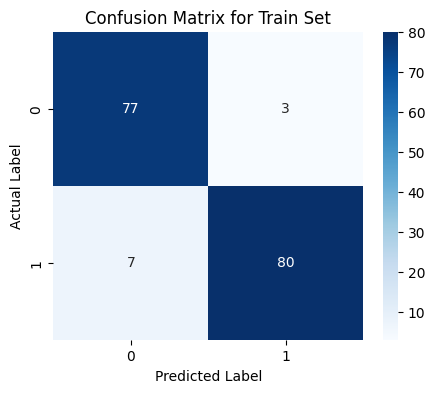

In [5]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, predicted)

print("Confusion Matrix:")
print(cm)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix for Train Set')
plt.show()